In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rock-paper-scissors-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F174293%2F393551%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240721%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240721T064824Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5807e2ca8a357e22a4124b851ca48ed3d656e5d963a2e4cddefc7cdc18da781c50c36b44bf2197edbba2603b8d012607c32e973715a8ec169ed1a8a2c287310ce6b066788865f06233a02420ecc47c9c0cba579c33bdb0bf0ed7f281f8ba2af332df5c06efdb4110f560af4c8d4414f29ddbd0680a7d011e30980413a6afc7d4f0d780e57969983b7f157ba8bcdf08fa3ebf74ce6cd5e7cae36a0e091e07915a16cab04296b3563c3b261eed277101e75ba8c630833b876d6a1408ca46597fd08c3e548b7d95270c3e240e26581ac98cd6dd6b207e7ee9515052ec2f62ff32394aee033e933b21083bfa7c87b24cffc73d38d3a07f4543083c5fac3b8a154737'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 474255368 bytes downloaded
Downloaded and uncompressed: rock-paper-scissors-dataset
Data source import complete.


## Rock Paper Scissors Image Recognition (Image Augmentation)

Given images of hands making rock, paper and scissors gestures, let's try to classify the gesture in a given image.

We will use a tensorflow/keras convolutional neural network to make our predictions.

### Importing Libraries

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
train_dir = '../input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train'
test_dir = '../input/rock-paper-scissors-dataset/Rock-Paper-Scissors/test'

### Visualizing Image Augmentation

In [4]:
sample_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    height_shift_range=0.2,
    width_shift_range = 0.2,
    zoom_range=0.2
)
sample_images = sample_generator.flow_from_directory(
    train_dir,
    target_size = (300,300),
    color_mode = 'rgb',
    class_mode = None,
    batch_size=1,
    shuffle=True,
    seed=42
)

Found 2520 images belonging to 3 classes.


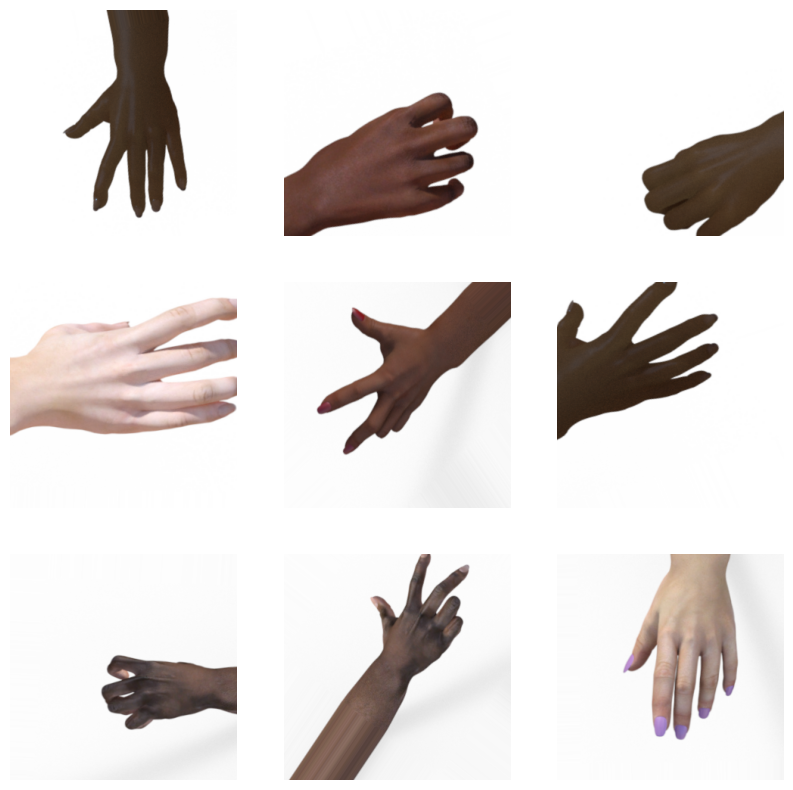

In [5]:
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = next(sample_images)[0]
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [6]:
next(sample_images)[0].shape

(300, 300, 3)

### Creating Generators

In [7]:
train_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    height_shift_range=0.2,
    width_shift_range = 0.2,
    zoom_range=0.2
)

test_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.7
)

In [11]:
train_images = train_generator.flow_from_directory(
    train_dir,
    target_size = (150,150),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size=1,
    shuffle=True,
    seed=42
)

val_images = test_generator.flow_from_directory(
    test_dir,
    target_size = (150,150),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size=1,
    shuffle=True,
    seed=42,
    subset='training'
)

test_images = test_generator.flow_from_directory(
    test_dir,
    target_size = (150,150),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size=1,
    shuffle=False,
    seed=42,
    subset='validation'
)

Found 2520 images belonging to 3 classes.
Found 114 images belonging to 3 classes.
Found 258 images belonging to 3 classes.


### Training

In [9]:
inputs = tf.keras.Input(shape=(150,150, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
258/258 [==============================] - 35s 114ms/step - loss: 5.6352 - accuracy: 0.7093 - val_loss: 0.9232 - val_accuracy: 0.5175
Epoch 2/100
258/258 [==============================] - 25s 97ms/step - loss: 0.4423 - accuracy: 0.8876 - val_loss: 5.0242 - val_accuracy: 0.3333
Epoch 3/100
258/258 [==============================] - 25s 96ms/step - loss: 0.1317 - accuracy: 0.9612 - val_loss: 2.2058 - val_accuracy: 0.5526
Epoch 4/100
258/258 [==============================] - 25s 96ms/step - loss: 0.2241 - accuracy: 0.9651 - val_loss: 1.6463 - val_accuracy: 0.5877
Epoch 5/100
258/258 [==============================] - 25s 95ms/step - loss: 0.1173 - accuracy: 0.9729 - val_loss: 1.7398 - val_accuracy: 0.5965
Epoch 6/100
258/258 [==============================] - 27s 105ms/step - loss: 0.3897 - accuracy: 0.9147 - val_loss: 1.3291 - val_accuracy: 0.5526


### Results

In [15]:
predictions = np.argmax(model.predict(test_images), axis=1)
predictions

258/258 [==============================] - 2s 7ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
test_images.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [20]:
cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1, 2])
clr = classification_report(test_images.labels, predictions, labels=[0, 1, 2], target_names=["Paper", "Rock", "Scissors"])

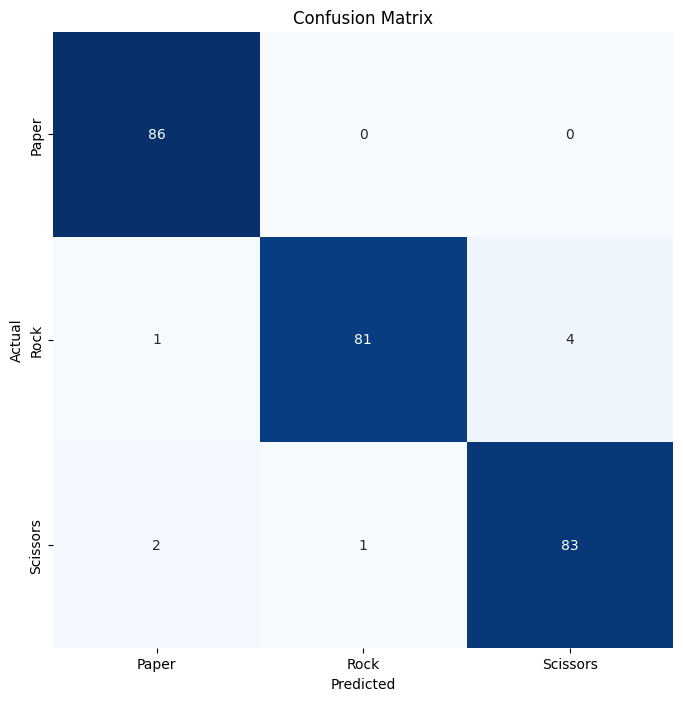

In [22]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Paper', 'Rock', 'Scissors'])
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Paper', 'Rock', 'Scissors'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [23]:
acc = model.evaluate(test_images, verbose=0)[1]
print("Accuracy: {:.2f}%".format(acc * 100))
print("Classification Report:\n-----------------\n", clr)

Accuracy: 96.90%
Classification Report:
-----------------
               precision    recall  f1-score   support

       Paper       0.97      1.00      0.98        86
        Rock       0.99      0.94      0.96        86
    Scissors       0.95      0.97      0.96        86

    accuracy                           0.97       258
   macro avg       0.97      0.97      0.97       258
weighted avg       0.97      0.97      0.97       258

